# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install -U scikit-learn

    100% |████████████████████████████████| 20.0MB 2.2MB/s eta 0:00:01
    100% |████████████████████████████████| 13.4MB 4.4MB/s eta 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:
      Successfully uninstalled scikit-learn-0.19.1


### Import Libraries

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy import stats

import pickle

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
#import xgboost as xgb

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score


# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
#!pip freeze > requirements.txt

### List of Functions

In [4]:
def convert_unknown_to_nan(df, keys_dict):
    """
    Replaces given keys from keys_dict to np.nan in df
    
    Input:
        df (DataFrame): Dataset for which keys to need to be converted nan 
        keys_dict: dictionary of column names with keys that need to be converted to nan

    """
    # Search for unknown keys in each column and replace

    for column_name in keys_dict:
        if column_name in df.columns:       
            keys_values = keys_dict[column_name]
            for key in keys_values:
                if key == 'X' or key == 'XX':
                    key = str(key)
                else:
                    key = int(key)
                
                df[column_name].replace(key, np.NaN, inplace=True)

#########################################################################################################

def drop_columns(df, missing_columns, threshold=0.3):
    """
    Columns with more than 30% missing values will be dropped.

    INPUT:
    - df: DataFrame to be cleaned
    - missing_columns: count of missing values per column
    - threshold: threshold as decision criteria for dropping (default 0.3)

    OUTPUT:
    - clean_df: DataFrame with a smaller percentage of missing values than threshold
    - drop_null_cols: List of columns that were dropped
    """
    
    column_missing_values_perc = missing_columns/len(df)                
    drop_null_cols = list(column_missing_values_perc[column_missing_values_perc>threshold].index)
    clean_df = df.drop(drop_null_cols, axis=1)
    
    return clean_df, drop_null_cols

#########################################################################################################

def drop_rows(df, threshold=0.3):
    """
    Rows with more than 30% missing values will be dropped.

    INPUT:
    - df: DataFrame to be cleaned
    - missing_rows: count of missing values per row
    - threshold: threshold as decision criteria for dropping (default 0.3)

    OUTPUT:
    - clean_df: DataFrame with a smaller percentage of missing values than threshold
    """
    missing_rows= df.isnull().sum(axis=1)
    clean_df = df[missing_rows / df.shape[1] <= threshold]
    
    return clean_df
    
#########################################################################################################    
    
def clean_data(df, unknown_values_dict, drop_cols, test_data=False):
    """
    Cleans the dataframe: 
    - Convert unknowns to NaN
    - Drop columns and rows with high amount of mising values and further unvaluable columns ('LNR')
    - Convert columns 'EINGEFUEGT_AM' and 'OST_WEST_KZ'
    
    Input:
        df: Dataset that needs to be cleaned up 
        unknown_values_dict: Dictionary containing column names with keys that need to be converted to nan
        drop_cols: list of columns to be dropped
        test_data (True/False): True if dataframe is mailout_test dataframe, here rows shouldn't be dropped

    Output:
        clean_df: Clean dataset
    """
    # Convert unknowns to NaN
    convert_unknown_to_nan(df, unknown_values_dict)
    
    # drop columns with more than 30% missing values
    clean_df = df.drop(drop_cols, axis=1)
    
    # drop columns with unique identifiers (here: "LNR")
    clean_df = clean_df.drop(['LNR'], axis=1)
    
    # drop rows with more than 30% missing values
    if test_data==False:
        clean_df = drop_rows(clean_df, threshold=0.3)
                             
    # Convert columns 'EINGEFUEGT_AM' and 'OST_WEST_KZ'
    clean_df['EINGEFUEGT_AM'] = pd.to_datetime(clean_df['EINGEFUEGT_AM'], format='%Y-%m-%d ').dt.year
    
    clean_df['OST_WEST_KZ'].replace('O', 0, inplace=True)
    clean_df['OST_WEST_KZ'].replace('W', 1, inplace=True)
    clean_df['OST_WEST_KZ'] = pd.to_numeric(clean_df['OST_WEST_KZ'], errors = 'coerce')
    

    return clean_df

#########################################################################################################

class Log1pTransformer(BaseEstimator, TransformerMixin):
    """
    Transforms skewed continuous data to log to get normal distributed data
    
    Input: 
    columns: List of columns to be log-transformed (not mandatory)
    
    Output:
    X_transformed: Dataframe with log-transformed data
    
    """
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for column in self.columns:
            try:
                X_transformed[column] = np.log1p(X_transformed[column])
            except ValueError:
                X_transformed[column] = np.NaN
        return X_transformed
    
#########################################################################################################


def int_to_str(column):
    """
    Custom function to convert integer to string  
    """
    return column.astype(str)

##########################################################################################################


def get_feature_weights(pca, component, column_names):
    """
    Returns weights of features for a selected component.
    
    Input:
    pca - PCA object
    component - PCA component number
    column_names - list of column names
    
    Output:
    df_features - DataFrame with feature weigths
    """
    
    weights_array = pca.components_[component]
    df_features = pd.DataFrame(weights_array, index = column_names, columns=['weight'])
    
    return df_features.sort_values(by='weight', ascending=False).round(2)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Load the data and basic evaluation
- read in csv files `Udacity_AZDIAS_052018.csv` and `Udacity_CUSTOMERS_052018.csv`
- basic data evaluation: shape, head, info, describe, isnull

In [5]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# basic data evaluation AZDIAS
print(azdias.shape)
print('----------------------------------------------------------------------------------------------------------------------')
print(azdias.head())
print('----------------------------------------------------------------------------------------------------------------------')
print(azdias.info())
print('----------------------------------------------------------------------------------------------------------------------')
print(azdias.describe())
print('----------------------------------------------------------------------------------------------------------------------')
print(azdias.isnull().sum())

(891221, 366)
----------------------------------------------------------------------------------------------------------------------
      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0

In [7]:
# basic data evaluation CUSTOMERS
print(customers.shape)
print('----------------------------------------------------------------------------------------------------------------------')
print(customers.head())
print('----------------------------------------------------------------------------------------------------------------------')
print(customers.info())
print('----------------------------------------------------------------------------------------------------------------------')
print(customers.describe())
print('----------------------------------------------------------------------------------------------------------------------')
print(customers.isnull().sum())

(191652, 369)
----------------------------------------------------------------------------------------------------------------------
      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                  10.0                  1.0   
1          NaN          NaN                   NaN                  NaN   
2          NaN          NaN                   0.0                  1.0   
3          NaN          NaN                   8.0                  0.0   
4          NaN          NaN                  14.0                  7.0

## Data Preprocessing Steps

- Explore features (Differences in columns)

- Check data types

- Explore features using `DIAS Attributes - Values 2017.xlsx`

- Missing Values 
    - Convert Unknown to NaN
    - Columns with NaN (distribution of % missing --> decide what to drop)
    - Rows with NaN (distribution of % missing --> decide what to drop)

- Datatypes: Classify attribute types (https://www.mygreatlearning.com/blog/types-of-data/)
    - Quantitative Attributes (Numerical)
        - Discrete / Continous data
    - Qualitative Attributes (Categorical)
    - Impute NaN for each data type?

- Encoding / Standardization (OneHotEncoder / StandardScaler)

### Explore Features 

In [8]:
# differences in columns
azdias_cols = set(azdias.columns)
customers_cols = set(customers.columns)
customers_cols - azdias_cols


{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

There are 3 columns in the customers data set not included in azdias data set: 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'.

### Check Data Types

In [9]:
# check data types azdias
azdias.get_dtype_counts()

float64    267
int64       93
object       6
dtype: int64

In [10]:
# check data types customers
customers.get_dtype_counts()

float64    267
int64       94
object       8
dtype: int64

In [11]:
print('Categorical features in AZDIAS:\n', azdias.select_dtypes(['object']).head(5))
print('----------------------------------------------------------------------------------------------------------------------')
print('Categorical features in CUSTOMERS:\n', customers.select_dtypes(['object']).head(5))

Categorical features in AZDIAS:
   CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015 D19_LETZTER_KAUF_BRANCHE  \
0            NaN             NaN             NaN                      NaN   
1             8A               8              51                      NaN   
2             4C               4              24            D19_UNBEKANNT   
3             2A               2              12            D19_UNBEKANNT   
4             6B               6              43               D19_SCHUHE   

         EINGEFUEGT_AM OST_WEST_KZ  
0                  NaN         NaN  
1  1992-02-10 00:00:00           W  
2  1992-02-12 00:00:00           W  
3  1997-04-21 00:00:00           W  
4  1992-02-12 00:00:00           W  
----------------------------------------------------------------------------------------------------------------------
Categorical features in CUSTOMERS:
   CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015 D19_LETZTER_KAUF_BRANCHE  \
0             1A               1              13  

There are 6 categorical features in the azdias data set but 8 categorical featrues in the customers data set. 

The feature information to these categorical features are the following:
- CAMEO_DEU_2015 / CAMEO_DEUG_2015 / CAMEO_INTL_2015: These describe the sociodemographic background of a person or household based on the CAMEO classification system.
- D19_LETZTER_KAUF_BRANCHE: Industry in which last purchase was made
- EINGEFUEGT_AM: Date where record was added 
- OST_WEST_KZ: Inidcates whether a house is located in West Germany / Federal Republik of Germany / FRG (W) or East Germany / German Democratic Republik / GDR (O)
- PRODUCT_GROUP: Product Group where the transactional activity has taken place
- CUSTOMER_GROUP: Classification of the customer as MULTI_BUYER or SINGLE_BUYER 

### Explore Features using DIAS Attributes - Values 2017.xlsx

In [12]:
# explore features using DIAS Attributes - Values 2017.xlsx
attr_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols='B:E', dtype='str')
attr_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,nan,nan,0,no classification possible
2,nan,nan,1,passive elderly
3,nan,nan,2,cultural elderly
4,nan,nan,3,experience-driven elderly


There are several values in the features that have the meaning "unknown". These should be replaced by NaN in the dataset in order to perform a correct estimation and cleanup of missing values.
Among numerical characteristics, there are many whose values have natural, ordered categories. These need to be identified and classified as ordinal or categorical data.

In [13]:
# identify values with meaning unknown
unknown_values = attr_values[attr_values["Meaning"].isin(["unknown","unknown / no main age detectable"])]
unknown_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


### Missing Values
- Convert Unknown to NaN
- Columns with NaN (distribution of % missing --> decide what to drop)
- Rows with NaN (distribution of % missing --> decide what to drop)

In [14]:
# Create dict of missing attribute-value combinations
unknown_values_dict = {}
for _, row in unknown_values.iterrows():
    key = row["Attribute"]
    unknown_values_dict[key] = row["Value"].split(", ")
    

In [15]:
# Manually add missing codes from other/similar attributes 
unknown_values_dict["CAMEO_INTL_2015"] = ['XX']
unknown_values_dict["CAMEO_DEUG_2015"] = ['X','XX']
unknown_values_dict["CAMEO_DEU_2015"] =['XX']
unknown_values_dict["GEBURTSJAHR"] = ['0']


In [16]:
# Checkpoint: Save to pickle
output = open('unknown_values_dict.pkl', 'wb')
pickle.dump(unknown_values_dict, output)
output.close()

In [17]:
# Number of missing values before converted to nan
azdias.isnull().sum().sort_values(ascending=False)

ALTER_KIND4                    890016
ALTER_KIND3                    885051
ALTER_KIND2                    861722
ALTER_KIND1                    810163
EXTSEL992                      654153
KK_KUNDENTYP                   584612
ALTERSKATEGORIE_FEIN           262947
D19_LETZTER_KAUF_BRANCHE       257113
D19_LOTTO                      257113
D19_VERSI_ONLINE_QUOTE_12      257113
D19_BANKEN_ONLINE_QUOTE_12     257113
D19_SOZIALES                   257113
D19_GESAMT_ONLINE_QUOTE_12     257113
D19_KONSUMTYP                  257113
D19_TELKO_ONLINE_QUOTE_12      257113
D19_VERSAND_ONLINE_QUOTE_12    257113
KBA05_MOTOR                    133324
KBA05_MOD8                     133324
KBA05_MOD4                     133324
KBA05_MOD3                     133324
KBA05_MOD2                     133324
KBA05_SEG1                     133324
KBA05_MOD1                     133324
KBA05_MAXVORB                  133324
KBA05_MAXSEG                   133324
KBA05_MAXHERST                 133324
KBA05_MAXBJ 

In [18]:
# Split df into samples to reduce data amount (to prevent Jupyter Kernel from dying)
azdias_1 = azdias.iloc[:300000]
azdias_2 = azdias.iloc[300000:600000]
azdias_3 = azdias.iloc[600000:]

In [19]:
# Convert unknowns to nan
convert_unknown_to_nan(azdias_1, unknown_values_dict)

# Trying to convert the whole azdias df the kernel of Jupyter died. Here just a sample is cleaned and used for the next steps. 

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [20]:
# Number of missing values AFTER converted to nan
azdias_1.isnull().sum().sort_values(ascending=False)

ALTER_KIND4                    299588
TITEL_KZ                       299287
ALTER_KIND3                    297884
ALTER_KIND2                    289969
ALTER_KIND1                    272523
AGER_TYP                       228509
EXTSEL992                      220605
KK_KUNDENTYP                   196589
KBA05_BAUMAX                   160091
GEBURTSJAHR                    132488
ALTER_HH                       104492
ALTERSKATEGORIE_FEIN            88786
D19_BANKEN_ONLINE_QUOTE_12      86621
D19_VERSAND_ONLINE_QUOTE_12     86621
D19_KONSUMTYP                   86621
D19_TELKO_ONLINE_QUOTE_12       86621
D19_SOZIALES                    86621
D19_GESAMT_ONLINE_QUOTE_12      86621
D19_LOTTO                       86621
D19_LETZTER_KAUF_BRANCHE        86621
D19_VERSI_ONLINE_QUOTE_12       86621
KKK                             53091
REGIOTYP                        53091
W_KEIT_KIND_HH                  49921
KBA05_MAXSEG                    49530
KBA05_MAXVORB                   49530
KBA05_ZUL3  

In [21]:
# selecting only columns with missing values
column_missing_values = azdias_1.isnull().sum().sort_values(ascending=False)
column_missing_values = column_missing_values[column_missing_values > 0]

print("There are {} columns with missing values.".format(len(column_missing_values)))

There are 280 columns with missing values.


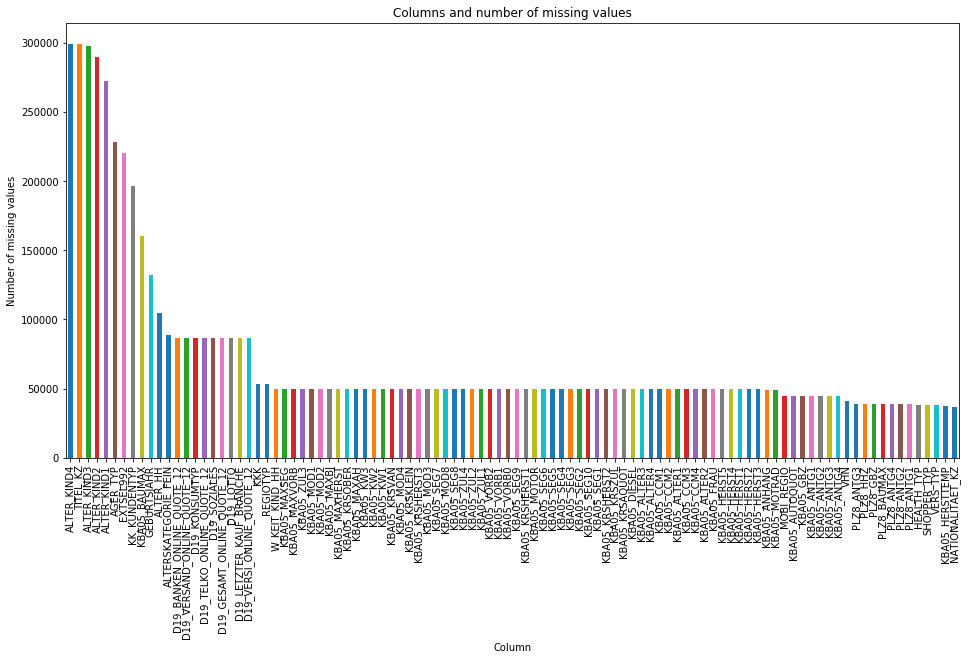

In [22]:
# Top 100 columns with highest count of missing values
column_missing_values.head(100).plot.bar(figsize=(16,8))
plt.title('Columns and number of missing values')
plt.xlabel('Column')
plt.ylabel('Number of missing values')
plt.savefig('missing_values.png', bbox_inches='tight')

plt.show()



In [23]:
# Share of missing values
column_missing_values_perc = column_missing_values/len(azdias_1) * 100
column_missing_values_perc

ALTER_KIND4                    99.862667
TITEL_KZ                       99.762333
ALTER_KIND3                    99.294667
ALTER_KIND2                    96.656333
ALTER_KIND1                    90.841000
AGER_TYP                       76.169667
EXTSEL992                      73.535000
KK_KUNDENTYP                   65.529667
KBA05_BAUMAX                   53.363667
GEBURTSJAHR                    44.162667
ALTER_HH                       34.830667
ALTERSKATEGORIE_FEIN           29.595333
D19_BANKEN_ONLINE_QUOTE_12     28.873667
D19_VERSAND_ONLINE_QUOTE_12    28.873667
D19_KONSUMTYP                  28.873667
D19_TELKO_ONLINE_QUOTE_12      28.873667
D19_SOZIALES                   28.873667
D19_GESAMT_ONLINE_QUOTE_12     28.873667
D19_LOTTO                      28.873667
D19_LETZTER_KAUF_BRANCHE       28.873667
D19_VERSI_ONLINE_QUOTE_12      28.873667
KKK                            17.697000
REGIOTYP                       17.697000
W_KEIT_KIND_HH                 16.640333
KBA05_MAXSEG    

9 columns have 50% or more missing values. Most of the columns have less than 20% missing values.


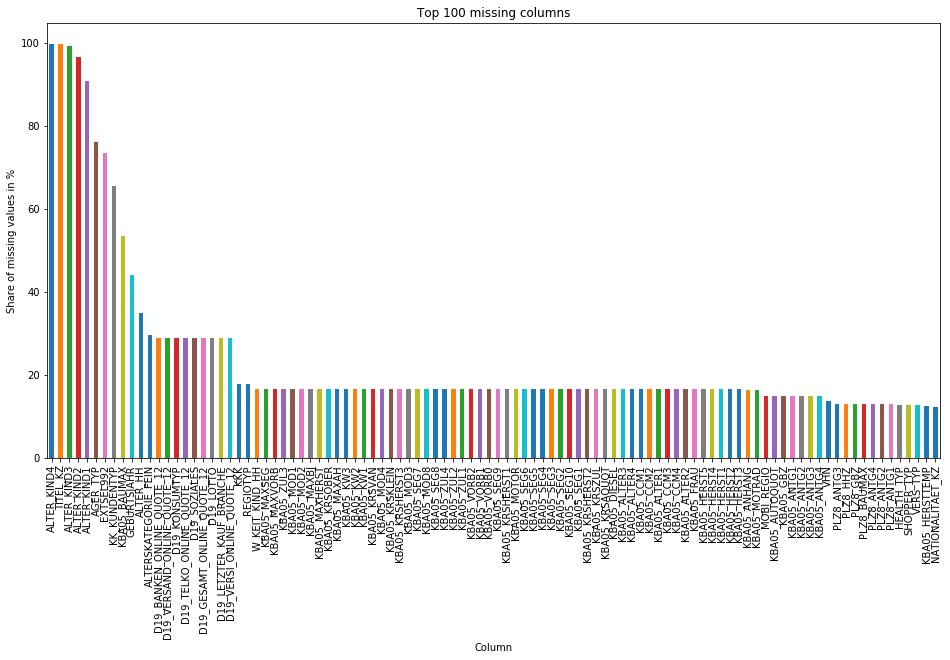

In [24]:
# Top 100 columns with highest share of missing values in %
column_missing_values_perc.head(100).plot.bar(figsize=(16,8))
plt.title('Top 100 missing columns')
plt.xlabel("Column")
plt.ylabel("Share of missing values in %")
plt.savefig('share_missing_values.png', bbox_inches='tight')

plt.show

print("9 columns have 50% or more missing values. Most of the columns have less than 20% missing values.")

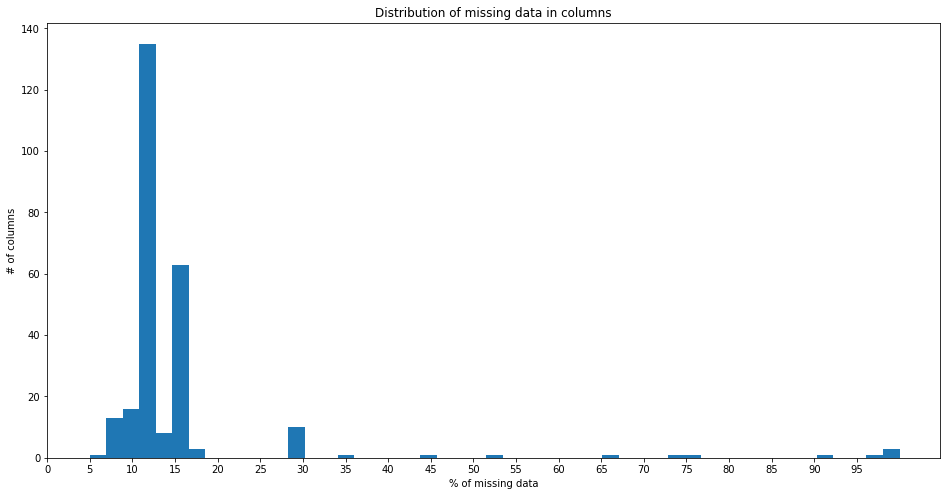

count    280.000000
mean      14.983386
std       14.037654
min        0.552333
25%       11.832000
50%       11.832000
75%       16.510000
max       99.862667
dtype: float64
----------------------------------------------------------------------------------------------------------------------
On average, columns have a missing share of 15.0%.
95% of columns have a missing share of 28.9% or less.


In [25]:
# Plot distribution of missing values
plt.figure(figsize=(16,8))
plt.hist(column_missing_values_perc, bins=np.linspace(5,100))
plt.title('Distribution of missing data in columns')
plt.xticks(np.arange(0, 100, 5))
plt.ylabel('# of columns')
plt.xlabel('% of missing data')
plt.savefig('distribution_missing_values.png', bbox_inches='tight')

plt.show()

print(column_missing_values_perc.describe())
print('----------------------------------------------------------------------------------------------------------------------')
print("On average, columns have a missing share of {}%.".format(round(column_missing_values_perc.mean(),1)))
print("95% of columns have a missing share of {}% or less.".format(round(column_missing_values_perc.quantile(0.95),1)))


In [26]:
# Drop columns with >30% missing values
azdias_dropped_cols, drop_null_cols = drop_columns(azdias_1, column_missing_values, 0.3)

print("{} columns have more than 30% missing values and will be will be dropped: {}".format(len(drop_null_cols),drop_null_cols))

11 columns have more than 30% missing values and will be will be dropped: ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


In [27]:
# Checkpoint: Save to pickle
# write list to a file
output = open('drop_null_cols.pkl', 'wb')
pickle.dump(drop_null_cols, output)
output.close()

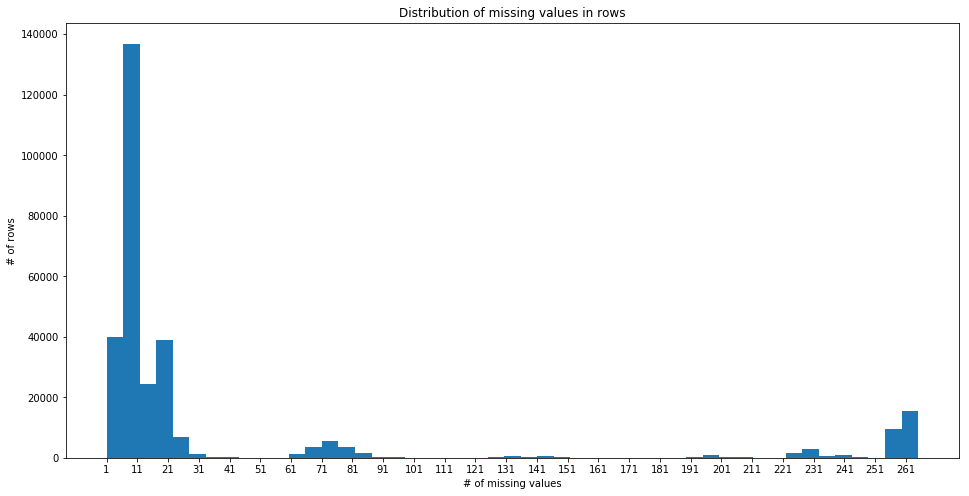

In [28]:
# Missing values in Rows:
missing_rows = azdias_1.isnull().sum(axis=1)

plt.figure(figsize=(16,8))
plt.hist(missing_rows, bins=np.linspace(min(missing_rows), max(missing_rows)+1))
plt.title('Distribution of missing values in rows');
plt.xticks(np.arange(min(missing_rows), max(missing_rows)+1, 10))
plt.ylabel('# of rows')
plt.xlabel('# of missing values')
plt.savefig('rows_missing_values.png', bbox_inches='tight')

plt.show()

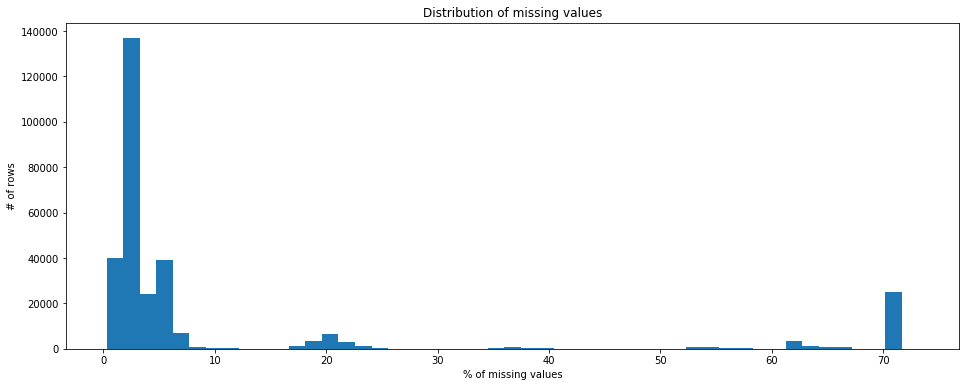

On average, rows have a missing share of 11.5%.
88.2% of rows have a missing share of 30% or less.


In [29]:
# Share of missing values per rows
row_missing_values_perc = 100*(missing_rows/azdias_1.shape[1])

plt.figure(figsize=(16,6))
plt.hist(row_missing_values_perc, bins=np.linspace(min(row_missing_values_perc), max(row_missing_values_perc)+1))
plt.ylabel('# of rows')
plt.xlabel('% of missing values')
plt.title('Distribution of missing values');
plt.savefig('dist_rows_missing_values.png', bbox_inches='tight')

plt.show() 

print("On average, rows have a missing share of {}%.".format(round(row_missing_values_perc.mean(),1)))
print("{}% of rows have a missing share of 30% or less.".format(round(100*(row_missing_values_perc.where(row_missing_values_perc < 30).count()/len(azdias_1)),1)))


In [30]:
azdias_dropped_rows = drop_rows(azdias_1, 0.3)

print("In total {}% of rows were dropped having >30% missing values.".format(round(100-100*azdias_dropped_rows.shape[0]/len(azdias_1),0)))

In total 12.0% of rows were dropped having >30% missing values.


### Clean Data

In [31]:
azdias_sample = azdias.iloc[:10000]
clean_azdias_sample = clean_data(azdias_sample, unknown_values_dict, drop_null_cols, test_data=False)
print(clean_azdias_sample.shape)
print("{} rows are dropped and {} columns.".format(azdias_sample.shape[0]-clean_azdias_sample.shape[0], azdias_sample.shape[1]-clean_azdias_sample.shape[1]))
clean_azdias_sample.head()

# Trying to clean the whole azdias df the kernel of Jupyter died. Here just a sample is cleaned and used for the next steps. 

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(8627, 354)
1373 rows are dropped and 12 columns.


,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


In [32]:
customers_sample = customers.iloc[:10000]
clean_customers_sample = clean_data(customers_sample.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1), unknown_values_dict, drop_null_cols, test_data=False)
print(clean_customers_sample.shape)
print("{} rows are dropped and {} columns.".format(customers_sample.shape[0]-clean_customers_sample.shape[0], customers_sample.shape[1]-clean_customers_sample.shape[1]))
clean_customers_sample.head()

(7219, 354)
2781 rows are dropped and 15 columns.


,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,1.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,1.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3
5,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,7.0,...,4.0,1.0,2.0,1.0,6.0,9.0,1.0,2,1,3


In [33]:
# Checkpoint: Save to pickle

clean_azdias_sample.to_pickle('clean_azdias_sample.pkl')
clean_customers_sample.to_pickle('clean_customers_sample.pkl')

### Classify attribute types

In [34]:
# if necessary, read pickle file
#clean_azdias_sample = pd.read_pickle('clean_azdias_sample.pkl')

In [35]:
# total number of numerical columns:
num_cols = clean_azdias_sample.select_dtypes(['float64', 'int64']).columns

binary_cols = []
for col in num_cols:
    n_unique = clean_azdias_sample[col].dropna().nunique()
    if n_unique == 2:
        binary_cols.append(col)
        
discrete_cols = list(clean_azdias_sample.select_dtypes(['int64']).columns)
continuous_cols = list(set(num_cols) - set(discrete_cols) - set(binary_cols))


# total number of categorical columns:
cat_cols = list(clean_azdias_sample.select_dtypes(['object']).columns)

print("Number of numerical columns: {} \nNumber of categorical columns: {}\n".format(len(num_cols), len(cat_cols)))

print("List of continuous columns: {} \n\nList of binary columns: {} \n\nList of discrete columns: {} \n\nList of categorical columns: {}".format(continuous_cols, binary_cols, discrete_cols, cat_cols))

Number of numerical columns: 350 
Number of categorical columns: 4

List of continuous columns: ['KONSUMNAEHE', 'D19_LOTTO', 'KBA13_SEG_SPORTWAGEN', 'KBA05_ALTER3', 'KBA13_TOYOTA', 'CJT_KATALOGNUTZER', 'PLZ8_HHZ', 'KBA13_KW_61_120', 'RT_SCHNAEPPCHEN', 'KBA05_ANTG2', 'KBA13_KW_90', 'KBA13_SEG_SONSTIGE', 'KBA13_ANTG3', 'KBA13_VW', 'VK_ZG11', 'KBA05_SEG5', 'KBA13_SEG_OBEREMITTELKLASSE', 'KBA05_CCM1', 'KBA13_KW_50', 'VHN', 'KBA13_CCM_2501', 'ARBEIT', 'KBA05_CCM2', 'UMFELD_ALT', 'D19_GESAMT_ONLINE_QUOTE_12', 'GEBAEUDETYP', 'KBA13_BAUMAX', 'KBA13_RENAULT', 'KBA05_MOD4', 'AKT_DAT_KL', 'SHOPPER_TYP', 'KBA05_ANTG4', 'CJT_TYP_5', 'KBA13_SITZE_5', 'KBA13_CCM_2000', 'KBA13_VORB_2', 'KBA13_HALTER_45', 'KBA13_SITZE_6', 'KBA05_KRSZUL', 'D19_TELKO_ONLINE_QUOTE_12', 'HEALTH_TYP', 'KBA05_MAXHERST', 'LP_FAMILIE_GROB', 'KBA05_HERST4', 'KBA05_KRSKLEIN', 'KBA13_KW_70', 'KBA13_SEG_GELAENDEWAGEN', 'KBA13_BJ_2000', 'KBA05_ZUL2', 'LP_LEBENSPHASE_GROB', 'KBA05_MAXSEG', 'KBA05_HERST1', 'D19_SOZIALES', 'KBA13_HALT

In [36]:
# Check for skewness
skewed_cols = []
for col in continuous_cols:
    try:
        skewness = skew(clean_azdias_sample[col].dropna())
        if abs(skewness) > 1:
                        skewed_cols.append(col)
    except:
         pass

# Normal columns
normal_cols = list(set(continuous_cols)-set(skewed_cols))


In [37]:
# Checkpoint: Save column lists to pickle
with open('num_cols.pkl', 'wb') as f:
    pickle.dump(num_cols, f)
    
with open('binary_cols.pkl', 'wb') as f:
    pickle.dump(binary_cols, f)
    
with open('discrete_cols.pkl', 'wb') as f:
    pickle.dump(discrete_cols, f)
    
with open('cat_cols.pkl', 'wb') as f:
    pickle.dump(cat_cols, f)

with open('skewed_cols.pkl', 'wb') as f:
    pickle.dump(skewed_cols, f)
    
with open('normal_cols.pkl', 'wb') as f:
    pickle.dump(normal_cols, f)
    

### Impute, encode and standardize features
- Quantitative Attributes (Numerical)
    - Discrete: Missing values of discrete features will be imputed based on the median value and standardized using StandardScaler()
    - Continous: All continuous features will be imputed based on median. Because there are some discrete features in the list due to their float datatype, the decimal should stay 0 after imputation. Skewed features will be log-transformed first and imputed based on the median value to avoid bias. All continuous features will be standardized with StandardScaler()
    - Binary: Missing values will be imputed based on the most common value.
- Qualitative Attributes (Categorical)
    - Categorical features will be one-hot encoded and then imputed on the most common value.

In [38]:
# Discrete features:
discrete_pipeline = Pipeline([
    ('discrete_impute', SimpleImputer(strategy='median')),
    ('discrete_scale', StandardScaler())
])

# Continuous features:

# Skewed continuous features:
skewed_pipeline = Pipeline([
    ('skewed_transform', Log1pTransformer(skewed_cols)),
    ('skewed_impute', SimpleImputer(strategy='median')),
    ('skewed_scale', StandardScaler())
])

# Normal disctributed continuous features:
normal_pipeline = Pipeline([
    ('normal_impute', SimpleImputer(strategy='median')),
    ('normal_scale', StandardScaler())
])

# Binary features:
binary_pipeline = Pipeline([(
    'binary_impute', SimpleImputer(strategy='most_frequent'))
])


# Categorical features:

categorical_pipeline = Pipeline([
    ('binary_impute', SimpleImputer(strategy='most_frequent')),
    ('string_conversion', FunctionTransformer(int_to_str, validate=False)),
    ('encoding', OneHotEncoder(sparse=False, handle_unknown ='ignore'))
])

# Combines Pipeline

transformers = [('discrete', discrete_pipeline, discrete_cols),
                ('skewed', skewed_pipeline, skewed_cols),
                ('normal', normal_pipeline, normal_cols),
                ('binary', binary_pipeline, binary_cols),
               ('categorical', categorical_pipeline, cat_cols)
               ]

column_transform = ColumnTransformer(transformers = transformers)


In [39]:
# Checkpoint: Save to pickle
filename = 'column_transform.sav'
pickle.dump(column_transform, open(filename, 'wb'))

### Transform Features

In [40]:
trans_azdias = column_transform.fit_transform(clean_azdias_sample)
print(trans_azdias)

[[-0.2449489  -0.31327087  0.45049544 ...  0.          0.
   0.        ]
 [-0.2449489  -0.31327087  0.45049544 ...  0.          0.
   0.        ]
 [-0.2449489  -0.31327087  0.45049544 ...  0.          0.
   0.        ]
 ...
 [-0.2449489  -0.31327087 -0.10139666 ...  1.          0.
   0.        ]
 [-0.2449489  -0.31327087  0.45049544 ...  0.          0.
   0.        ]
 [-0.2449489  -0.31327087  0.45049544 ...  0.          0.
   0.        ]]


In [41]:
onehot_categories = column_transform.transformers_[4][1][2].categories_
onehot_categories

[array(['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B',
        '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D',
        '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C',
        '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E'],
       dtype='<U22'),
 array(['1', '1.0', '2', '2.0', '3', '3.0', '4', '4.0', '5', '5.0', '6',
        '6.0', '7', '7.0', '8', '8.0', '9', '9.0'], dtype='<U22'),
 array(['12', '12.0', '13', '13.0', '14', '14.0', '15', '15.0', '22',
        '22.0', '23', '23.0', '24', '24.0', '25', '25.0', '31', '31.0',
        '32', '32.0', '33', '33.0', '34', '34.0', '35', '35.0', '41',
        '41.0', '43', '43.0', '44', '44.0', '45', '45.0', '51', '51.0',
        '52', '52.0', '54', '54.0', '55', '55.0'], dtype='<U22'),
 array(['D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
        'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
        'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_C

In [42]:
# Convert numpy array to dataframe
onehot_cols = list(column_transform.transformers_[4][1][2].get_feature_names())
all_column_names = discrete_cols + skewed_cols + normal_cols + binary_cols + onehot_cols
trans_azdias = pd.DataFrame(trans_azdias, columns=[all_column_names])
trans_azdias.head()

,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,...,x3_D19_SONSTIGE,x3_D19_TECHNIK,x3_D19_TELKO_MOBILE,x3_D19_TELKO_REST,x3_D19_TIERARTIKEL,x3_D19_UNBEKANNT,x3_D19_VERSAND_REST,x3_D19_VERSICHERUNGEN,x3_D19_VOLLSORTIMENT,x3_D19_WEIN_FEINKOST
0,-0.244949,-0.313271,0.450495,-0.468698,-0.362300,-0.133597,0.135742,0.382934,-0.292776,-0.315904,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.244949,-0.313271,0.450495,-0.468698,-0.362300,-0.133597,0.135742,0.382934,-0.292776,-0.315904,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.244949,-0.313271,0.450495,-0.468698,-0.362300,-0.133597,0.135742,0.382934,-0.292776,-0.315904,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4.942876,6.045759,-2.308965,0.013067,0.816045,-0.133597,0.135742,-2.723091,3.579137,3.476259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.244949,-0.313271,0.450495,-0.468698,-0.362300,-0.133597,0.135742,0.382934,-0.292776,-0.315904,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
trans_azdias.shape

(8627, 492)

In [44]:
# Checkpoint: Save columns names to pickle
with open('all_column_names.pkl', 'wb') as f:
    pickle.dump(all_column_names, f)

In [45]:
# Check if all ciólumns are of type float
trans_azdias.dtypes.value_counts()

float64    492
dtype: int64

In [46]:
trans_customers = column_transform.fit_transform(clean_customers_sample)

In [47]:
# Convert numpy array to dataframe
trans_customers = pd.DataFrame(trans_customers, columns=[all_column_names])
trans_customers.head()

,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,...,x3_D19_SONSTIGE,x3_D19_TECHNIK,x3_D19_TELKO_MOBILE,x3_D19_TELKO_REST,x3_D19_TIERARTIKEL,x3_D19_UNBEKANNT,x3_D19_VERSAND_REST,x3_D19_VERSICHERUNGEN,x3_D19_VOLLSORTIMENT,x3_D19_WEIN_FEINKOST
0,-0.246343,-0.316365,0.456808,-0.429128,-0.340636,-0.165338,0.199134,0.340994,-0.336377,-0.556025,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.246343,-0.316365,0.456808,-0.429128,-0.340636,-0.165338,0.199134,0.340994,-0.336377,-0.556025,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.246343,-0.316365,0.456808,-0.429128,-0.340636,-0.165338,0.199134,0.340994,-0.336377,-0.556025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.891101,2.700593,-3.399504,2.074409,-0.340636,2.806219,0.199134,-1.628839,-0.336377,-0.556025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.246343,-0.316365,0.456808,-0.429128,-0.340636,-0.165338,0.199134,0.340994,-0.336377,-0.556025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
trans_customers.shape

(7219, 492)

In [49]:
# Checkpoint: Save to pickle
trans_azdias.to_pickle('trans_azdias.pkl')
trans_customers.to_pickle('trans_customers.pkl')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

PCA
- Apply PCA
- Plot cumulative explained variance (y) per number of components (x) -> decide how many components are necessary to explain the variance (variance treshhold somewhere between 80-95%)
- Apply PCA with reduced number of components
- Analyze the top three components and the columns with highest weight in each of the components --> gives idea about columns with highest importance/influence

Clustering
- Apply K-Means
- Plot elbow curve to determine number of clusters
- Create pipeline
- Predict clusters for azdias and customer data set
- Compare custer sizes of both datasets: plot population_count and customers_count per cluster (in %)
- Analyze overrepresentated and underrepresentated clusters from customer data set

In [50]:
# If necessary, read trans_azdias
#trans_azdias = pd.read_pickle('trans_azdias.pkl')

### PCA

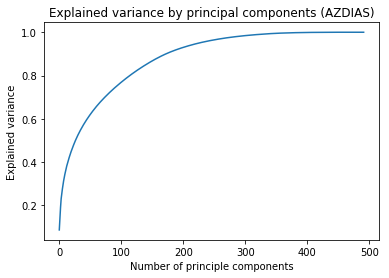

In [51]:
# Cumulative variance per number of components (AZDIAS)

pca = PCA()
pca_full_azdias = pca.fit_transform(trans_azdias)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance by principal components (AZDIAS)')
plt.xlabel('Number of principle components')
plt.ylabel('Explained variance')
plt.savefig('explained_variance.png', bbox_inches='tight')

plt.show()

The chart above shows the cumulative explained data variance by principal components.
We want to keep a small number of features while maintaining a high explained data variance. To decide how many principal components to include, we need to check how much data variance the components capture. From the graph, we can conclude that 100 features can explain about 80% of the data variance. We would only lose 20% of variance while reducing the number of components by almost 400.

Due to Jupyter Kernel issues, number of components needed to be reduced to 50 with a variance reduction of around 50%.

In [52]:
# Apply PCA with reduced number of components
#pca = PCA(n_components=200)
#pca = PCA(n_components=100)
pca = PCA(n_components=50)
pca_reduced_azdias = pd.DataFrame(pca.fit_transform(trans_azdias))

In [53]:
# Checkpoint: Save to pickle
pca_reduced_azdias.to_pickle('pca_reduced_azdias.pkl')

In [54]:
# If necessary, read pca_reduced_azdias
#pca_reduced_azdias = pd.read_pickle('pca_reduced_azdias.pkl')

In [55]:
# Analyze top three components
top_three_comp = pca.explained_variance_ratio_[:3]
print("The first three components maintain {:.1%} of data variance.".format(top_three_comp.sum()))

The first three components maintain 19.0% of data variance.


In [56]:
print("Variance explained by component 1: {:.1%}\nComponent determined by: ".format(top_three_comp[0]))
get_feature_weights(pca, 0, trans_azdias.columns).head()

Variance explained by component 1: 8.6%
Component determined by: 


,weight
MOBI_REGIO,0.13
LP_STATUS_FEIN,0.13
KBA13_ANTG1,0.13
PLZ8_ANTG1,0.13
LP_STATUS_GROB,0.13


In [57]:
get_feature_weights(pca, 0, trans_azdias.columns).tail()

,weight
KBA13_BAUMAX,-0.13
PLZ8_ANTG3,-0.13
KBA13_ANTG3,-0.13
ANZ_STATISTISCHE_HAUSHALTE,-0.13
ANZ_HAUSHALTE_AKTIV,-0.13


The first component is mainly determined by the mobility of a person and the social status.

In [58]:
print("Variance explained by component 2: {:.1%}\nComponent determined by: ".format(top_three_comp[1]))
get_feature_weights(pca, 1, trans_azdias.columns).head()

Variance explained by component 2: 5.3%
Component determined by: 


,weight
ONLINE_AFFINITAET,0.14
D19_GESAMT_ANZ_24,0.14
D19_GESAMT_ANZ_12,0.13
D19_VERSAND_ANZ_24,0.13
PRAEGENDE_JUGENDJAHRE,0.12


In [59]:
get_feature_weights(pca, 1, trans_azdias.columns).tail()

,weight
VK_DHT4A,-0.12
D19_VERSAND_DATUM,-0.13
D19_GESAMT_DATUM,-0.13
D19_VERSAND_ONLINE_DATUM,-0.13
D19_GESAMT_ONLINE_DATUM,-0.14


The second component is mainly determined by the online affinity, transaction activities and formative events in the individual's youth.

In [60]:
print("Variance explained by component 3: {:.1%}\nComponent determined by: ".format(top_three_comp[2]))
get_feature_weights(pca, 2, trans_azdias.columns).head()

Variance explained by component 3: 5.0%
Component determined by: 


,weight
KBA13_HERST_BMW_BENZ,0.17
KBA13_MERCEDES,0.15
KBA13_SEG_OBEREMITTELKLASSE,0.15
KBA13_BMW,0.14
KBA13_SITZE_4,0.14


In [61]:
get_feature_weights(pca, 2, trans_azdias.columns).tail()

,weight
KBA13_HALTER_25,-0.11
KBA13_HALTER_20,-0.11
KBA13_KMH_140_210,-0.12
KBA13_SEG_KLEINWAGEN,-0.12
KBA13_SITZE_5,-0.14


The third component is primarily influenced by the type of car a person owns.

### Clustering

In [62]:
# If necessary, read pickle files
clean_azdias_sample = pd.read_pickle('clean_azdias_sample.pkl')
clean_customers_sample = pd.read_pickle('clean_customers_sample.pkl')

trans_azdias = pd.read_pickle('trans_azdias.pkl')
trans_customers = pd.read_pickle('trans_customers.pkl')

pca_reduced_azdias = pd.read_pickle('pca_reduced_azdias.pkl')

In [ ]:
# Apply K-Means Clustering
distances = []
k = list(range(1, 21))

for i in k:
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(pca_reduced_azdias)
    distances.append(kmeans.inertia_)

In [ ]:
# Checkpoint: Save distances to pickle
with open('distances.pkl', 'wb') as f:
    pickle.dump(distances, f)

In [ ]:
# Read pickle file if necessary
with open('distances.pkl', 'rb') as f:
    distances = pickle.load(f)

In [ ]:
 # Plot Elbow Curve to determine number of clusters (k)
plt.figure(figsize=(16,8))
plt.plot(list(range(1, 21)), distances, '-x')
plt.title('Elbow Curve')
plt.xlabel("Number of clusters k")
plt.ylabel("Sum of squared distances")
plt.xticks(list(range(1,21)))
plt.savefig('elbow.png', bbox_inches='tight')

plt.show()

Using the elbow chart, I can see a significant drop in the sum of squared distances up to 10 clusters. This cluster number is chosen as parameter for the following steps.

In [6]:
# Create pipeline and predict clusters for azdias and customer data set
n_components = 50
n_clusters = 10


clustering_pipeline = Pipeline([
    ('reduce', PCA(n_components = n_components)),
    ('cluster', KMeans(n_clusters = n_clusters, init = 'k-means++'))
])

In [7]:
# Fit clustering pipeline and predict clusters for azdias and customer data set
clustering_pipeline.fit(trans_azdias)
clustered_azdias = pd.DataFrame(clustering_pipeline.predict(trans_azdias), columns = ['Cluster'])
clustered_customers = pd.DataFrame(clustering_pipeline.predict(trans_customers), columns = ['Cluster'])

In [ ]:
# Checkpoint: Save to pickle
clustered_azdias.to_pickle('clustered_azdias.pkl')
clustered_customers.to_pickle('clustered_customers.pkl')

In [4]:
#If necessary read pickle files
clustered_azdias = pd.read_pickle('clustered_azdias.pkl')
clustered_customers = pd.read_pickle('clustered_customers.pkl')

In [5]:
clustered_azdias

,Cluster
0,4
1,0
2,3
3,6
4,3
5,0
6,0
7,4
8,8
9,7


In [6]:
# Analyze cluster sizes and portion per cluster (%)
cluster_share = pd.DataFrame([])

cluster_share['Population'] = clustered_azdias['Cluster'].value_counts().sort_index()
cluster_share['Customer'] = clustered_customers['Cluster'].value_counts().sort_index()
cluster_share.reset_index(inplace=True)
cluster_share.rename(columns={"index":"Cluster"}, inplace=True)
cluster_share['Cluster'] = cluster_share['Cluster']+1
cluster_share['Population_%'] = (cluster_share['Population'] / (cluster_share['Population'].sum()) * 100).round(2)
cluster_share['Customer_%'] = (cluster_share['Customer'] / (cluster_share['Customer'].sum()) * 100).round(2)

cluster_share

,Cluster,Population,Customer,Population_%,Customer_%
0,1,1202,63,13.93,0.87
1,2,894,111,10.36,1.54
2,3,529,180,6.13,2.49
3,4,1117,1396,12.95,19.34
4,5,663,291,7.69,4.03
5,6,615,127,7.13,1.76
6,7,697,214,8.08,2.96
7,8,991,857,11.49,11.87
8,9,757,2478,8.77,34.33
9,10,1162,1502,13.47,20.81


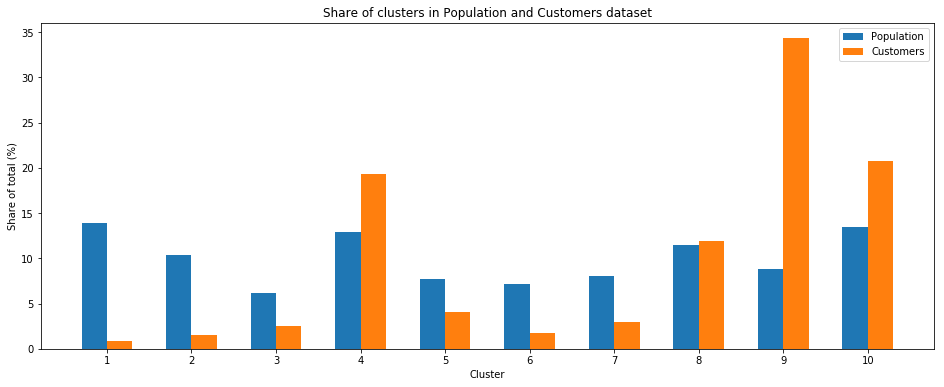

In [9]:
# Plot Cluster Share
n_clusters = 10

fig, ax = plt.subplots(figsize=(16,6))

x = np.arange(n_clusters)
bar_width = 0.3    

p1 = ax.bar(x, cluster_share['Population_%'], bar_width, bottom=0)
p2 = ax.bar(x + bar_width, cluster_share['Customer_%'], bar_width, bottom=0)

ax.set_title('Share of clusters in Population and Customers dataset')
ax.set_ylabel('Share of total (%)')
ax.set_xlabel('Cluster')

ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(cluster_share['Cluster'])
ax.legend((p1[0], p2[0]), ('Population', 'Customers'))

ax.autoscale_view()

fig.savefig('cluster_share.png', bbox_inches='tight')


The proportion of data points per cluster is relatively evenly distributed for the Population dataset. In the case of the Customer data, however, we see that the distribution is unbalanced. More than 80% of the data points are assigned to clusters 4, 8, 9 and 10 and only a very small proportion is assigned to the remaining clusters.

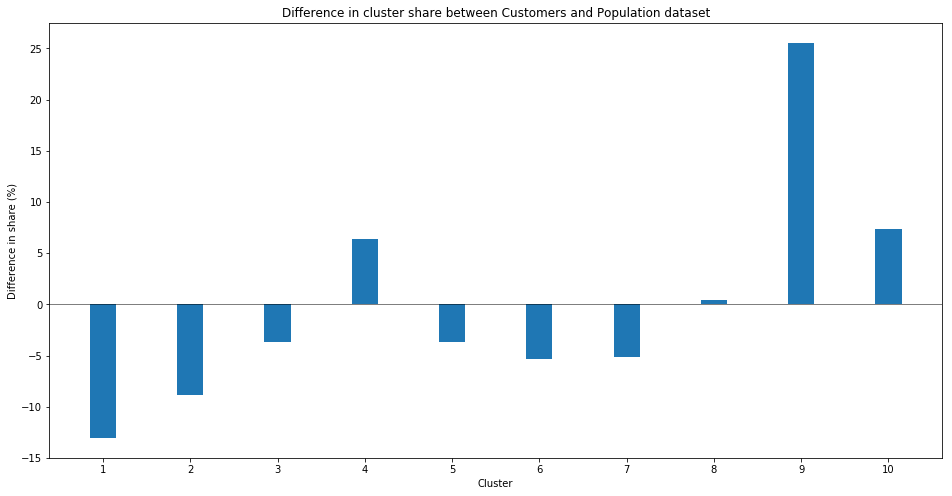

In [10]:
# Analyze the cluster share differences
cluster_share['Difference_%'] = cluster_share['Customer_%']-cluster_share['Population_%']

fig, ax = plt.subplots(figsize=(16,8))
x = np.arange(n_clusters)
width = 0.3

p1 = ax.bar(x, cluster_share['Difference_%'], width)

ax.set_title('Difference in cluster share between Customers and Population dataset')
ax.set_ylabel('Difference in share (%)')
ax.set_xlabel('Cluster')

ax.axhline(linewidth=.5, color='black')

ax.set_xticks(x)
ax.set_xticklabels(cluster_share['Cluster'])
ax.autoscale_view()

fig.savefig('cluster_share_diff.png', bbox_inches='tight')


The difference plot clearly shows once again that clusters 4, 9 and 10 are overrepresented in the Customer data set. Clusters 1 and 2, on the other hand, show the greatest underrepresentation.
Groups 4, 9 and 10 should therefore be focused on for the marketing campaign.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [6]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
mailout_train.shape

(42962, 367)

In [8]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


### Prepare Data

In [12]:
# If necessary, read pickle files
unknown_values_dict = open('unknown_values_dict.pkl', 'rb')
unknown_values_dict = pickle.load(unknown_values_dict)

drop_null_cols = open('drop_null_cols.pkl', 'rb')
drop_null_cols = pickle.load(drop_null_cols)

column_transform = pickle.load(open('column_transform.sav', 'rb'))

with open('all_column_names.pkl', 'rb') as f:
    all_column_names = pickle.load(f)

In [19]:
# Preprocess data
# Clean dataset
clean_mailout_train = clean_data(mailout_train.drop('RESPONSE', axis=1), unknown_values_dict, drop_null_cols, test_data = True)

X = clean_mailout_train
y = mailout_train['RESPONSE']

print(X.shape)


(42962, 354)


In [18]:
# Checkpoint save to pickle
clean_mailout_train.to_pickle('clean_mailout_train.pkl')

In [ ]:
# If necessary, read pickle file
#clean_mailout_train = pd.read_pickle('clean_mailout_train.pkl')

In [20]:
# Transform dataset
X_trans = column_transform.fit_transform(X)

In [22]:
# Checkpoint save to pickle
with open('X_trans.pkl', 'wb') as f:
    pickle.dump(X_trans, f)

### Fit Model

Now that the training data is prepared, a model can be fitted with this data. First, we train some models with their default parameters and evaluate their performance.

The evaluation metric we use is AUC for the ROC curve. A Receiver Operating Characteristic (ROC) curve is a graph that plots the true positive rate (TPR, also known as recall, proportion of actual customers correctly identified) against the false positive rate (FPR, proportion of non-customers identified as customers).

Based on the AUC ROC score, a model is selected and the parameters are hypertuned to identify the best model.

In [23]:
def train_classifier(classifier, param_grid, X=X_trans, y=y):
    """
    Fit a classifier using GridSearchCV, compute ROC AUC metric
    
    INPUT:
    - classifier (classifier): classifier to fit 
    - param_grid (dict): parameters of the classifier used with GridSearchCV
    - X (DataFrame): features of the training dataframe
    - y (DataFrame): labels of the training dataframe
            
    OUTPUT:
    - grid.best_estimator_: fitted classifier

    """
    
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    
    print('ROC AUC score:', grid.best_score_)
    
    return grid.best_estimator_

In [24]:
# Models to test
models = {
          'RFC': RandomForestClassifier(random_state=10), 
          'ABC': AdaBoostClassifier(random_state=10), 
          'GBC': GradientBoostingClassifier(random_state=10)
         }


In [25]:
print(train_classifier(models['RFC'], {}))


ROC AUC score: 0.6026940282277659
RandomForestClassifier(random_state=10)


In [26]:
print(train_classifier(models['ABC'], {}))


ROC AUC score: 0.7146833262731156
AdaBoostClassifier(random_state=10)


In [27]:
print(train_classifier(models['GBC'], {}))


ROC AUC score: 0.751600269727608
GradientBoostingClassifier(random_state=10)


The highest ROC AUC score was achived with the GradientBoostingClassifier. It will be used as best model and its parameters finetuned in a next step. 

In [29]:
# Parameter fine tuning

gbc = models['GBC']

param_grid = {'loss': ['deviance', 'exponential'],
              'max_depth': [2, 3],
              'n_estimators':[50,70]
             }

gbc_best_est = train_classifier(gbc, param_grid)
gbc_best_est

ROC AUC score: 0.7593755123471799


GradientBoostingClassifier(n_estimators=50, random_state=10)

In [30]:
# Checkpoint: Save to pickle
filename = 'gbc_best_est.sav'
pickle.dump(gbc_best_est, open(filename, 'wb'))

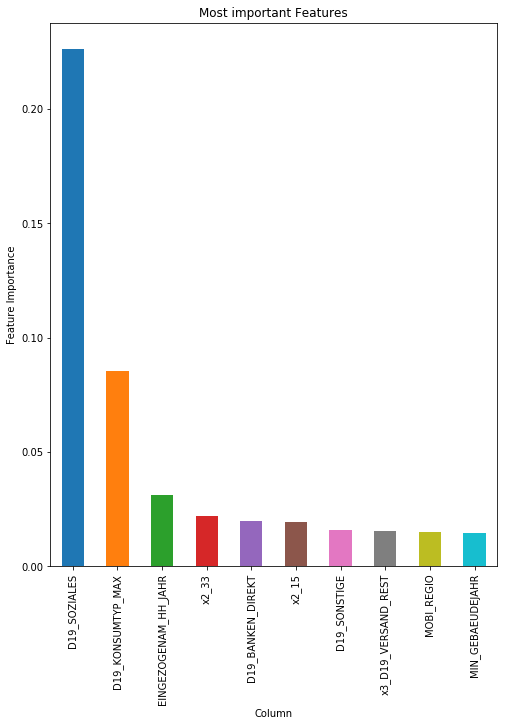

In [46]:
# Plot most important features
feature_importances = gbc_best_est.feature_importances_
pd.Series(feature_importances, all_column_names).sort_values(ascending=False)[:10].plot(kind='bar', figsize=(8,10))
plt.title('Most important Features')
plt.xlabel('Column')
plt.ylabel('Feature Importance')
plt.savefig('feature_importance.png', bbox_inches='tight');

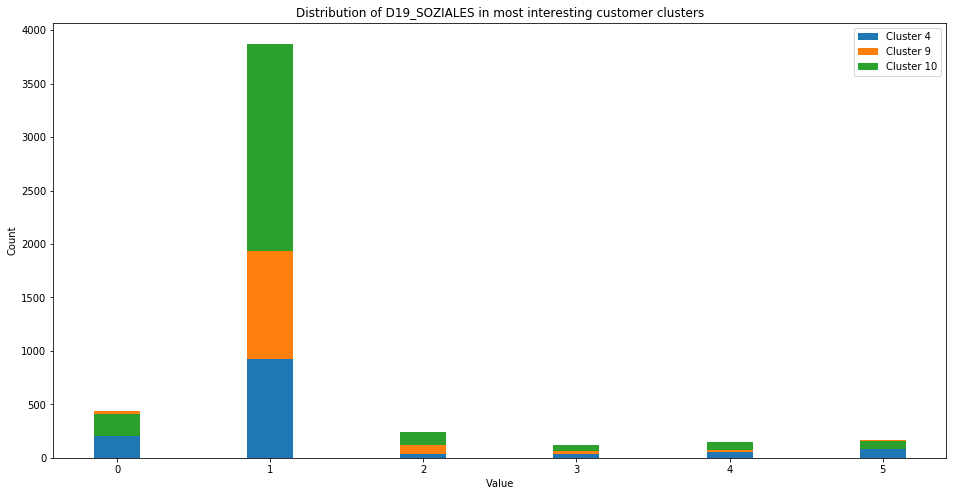

In [126]:
# How is most important column distributed in most important customer clusters
clean_customers_sample = pd.read_pickle('clean_customers_sample.pkl')
clustered_customers = pd.read_pickle('clustered_customers.pkl')

bins = range( int(min(clean_customers_sample['D19_SOZIALES'])), int(max(clean_customers_sample['D19_SOZIALES'])+1))

# Plot D19_SOZIALES distribution in relevant clusters
x1=clean_customers_sample.iloc[clustered_customers[clustered_customers['Cluster'] == 3].index]['D19_SOZIALES'].value_counts().reset_index().sort_values(by ='index')
x2=clean_customers_sample.iloc[clustered_customers[clustered_customers['Cluster'] == 8].index]['D19_SOZIALES'].value_counts().reset_index().sort_values(by ='index')
x3=clean_customers_sample.iloc[clustered_customers[clustered_customers['Cluster'] == 9].index]['D19_SOZIALES'].value_counts().reset_index().sort_values(by ='index')

x = x1['index']

y1= np.array(x1['D19_SOZIALES'])
y2= np.array(x2['D19_SOZIALES'])
y3= np.array(x3['D19_SOZIALES'])

plt.figure(figsize=(16,8))
width = 0.3

plt.bar(x, y1, width = width, label= 'Cluster 4')
plt.bar(x, y2, width = width, bottom=y1, label= 'Cluster 9')
plt.bar(x, y2, width = width, bottom=y2, label= 'Cluster 10')

plt.title('Distribution of D19_SOZIALES in most interesting customer clusters')
plt.ylabel('Count')
plt.xlabel('Value')
plt.legend()
plt.savefig('d19_distribution.png', bbox_inches='tight');

plt.show()

### Classify Test Data
- Load Test dataset
- Preprocess data
- Predict RESPONSE

In [127]:
# Load data
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [128]:
mailout_test.shape

(42833, 366)

In [129]:
# load pkl files if necessary
unknown_values_dict = open('unknown_values_dict.pkl', 'rb')
unknown_values_dict = pickle.load(unknown_values_dict)

drop_null_cols = open('drop_null_cols.pkl', 'rb')
drop_null_cols = pickle.load(drop_null_cols)

column_transform = pickle.load(open('column_transform.sav', 'rb'))
    
with open('all_column_names.pkl', 'rb') as f:
    all_column_names = pickle.load(f)

In [131]:
# Preprocess data
# Clean dataset
clean_mailout_test = clean_data(mailout_test, unknown_values_dict, drop_null_cols, test_data = True)

# Transform dataset
trans_mailout_test = column_transform.fit_transform(clean_mailout_test)


In [133]:
# Checkpoint: Save to pickle
with open('trans_mailout_test.pkl', 'wb') as f:
    pickle.dump(trans_mailout_test, f)

In [134]:
# Predict RESPONSE
response_test = gbc_best_est.predict_proba(trans_mailout_test)
response_test

array([[0.96693247, 0.03306753],
       [0.97147381, 0.02852619],
       [0.99544897, 0.00455103],
       ...,
       [0.98267133, 0.01732867],
       [0.97705194, 0.02294806],
       [0.97413891, 0.02586109]])

In [142]:
# Final Result
final_result = pd.DataFrame({'LNR':mailout_test['LNR'], 'RESPONSE':response_test[:, 0]})
final_result['ROUNDED'] = round(final_result['RESPONSE'],0)
print(final_result['ROUNDED'].value_counts())


1.0    42815
0.0       18
Name: ROUNDED, dtype: int64
42815
